# Robust Transformer-Based Approach for Intrusion Detection System

Implementation by Malte Andersch, Student-ID 5571996

In this Notebook, I will explore and experiment with the Proposed [RTIDS](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9794665) Architecture by Wu et Al. I will first describe the individual Components before evaluating the Performance of the Model and analyzing the Results. Finally I will compare the Perfformance of the RTIDS Archtiecture with an Encoder-Only Approach to the Same Problem.

For running any of the code samples, please install the requirements listed below. You will also need to install PyTorch, but since the exact command depends on your system and conda/pip, I will not list any command for it here.

In [ ]:
!pip install einops
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install imbalanced-learn

## Architecture

### Embedding
In Network Intrusion Detection Systems, we mostly work with Numerical Values and not specific Tokens, thus we cannot apply traditional Token Embedding Techniques. However, since the authors of RTIDS did not specify their chosen Approach, I opted for the "Feature Tokenizer" Approach, described by Gorishniy et Al. in [Revisiting Deep Learning Models for Tabular Data](https://arxiv.org/pdf/2106.11959v2.pdf), thus normalizing all numerical Values in the Range 0. - 1. and then applying a linear Transformation to obtain a vector of the model dimension for each Attribute. While the Normalization happens in Data Preprocessing, the Linear Transformation is (since it is a Trainable Parameter) applied in the Embedder Module.

In [1]:
from torch import nn
import torch 
from einops import rearrange

class RTIDS_Embedder(nn.Module):
    def __init__(self, dim, num_numerical_types=78):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(num_numerical_types, dim))
        self.biases = nn.Parameter(torch.randn(num_numerical_types, dim))

    def forward(self, x):
        x = rearrange(x, 'b n -> b n 1')
        return x * self.weights + self.biases

### Positional Encoding
Since the linear Operations of a Transformer Model would ignore any sort of positional Relation between Features, we apply Positional Encoding to the Input. Here we use Standard trigonometric Functions to add positional Information to each Attribute. The following calculation is performed:
$$PE(pos, 2i) = \sin(pos/1000^{2i/d\_model})$$
$$PE(pos, 2i+1) = \cos(pos/1000^{2i/d\_model})$$

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
from math import cos, sin, sqrt

class RTIDS_Positional_Encoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 78):
        super().__init__()
        self.d_model = d_model

        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0,d_model,2):
                pe[pos,i] = sin(pos / (1000**(i/d_model)))
                pe[pos,i+1] = cos(pos / (1000**(i/d_model)))
        
        pe = pe.unsqueeze(0)
        self.register_buffer("pe",pe)
    
    def forward(self, x):
        x = x * sqrt(self.d_model)
        seq_len = x.size(1)
        y = Variable(self.pe[:,:seq_len],requires_grad=False).cuda()
        x = x + y
        return x

### Attention
The Multi-Head Attention Mechanism is the Core part of any Transformer Model. Despite unclear definitions in the original RTIDS Paper regarding their use of the Multi-Headed Approach (Images displaying each Head as analyzing a different Sequence instead of the same Sequence with different sections of the Weight Matrix) I used the well-known implementation for the attention mechanism.
The Attention Module decribed below is used for Multi-Headed Attention as well as for Masked Multi-Head Attention.
The general calculation is seen in this formula:

$$Attention(Q,K,V) = softmax\left(M+\frac{QK^T}{\sqrt{d_k}}\right)$$

Where Q, K, V represent the Query, Key and Value Matrices, $d_k$ represents their dimension and $M$ is the Mask Matrix.

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import math

def attention(q, k, v, d_k, mask=None, dropout=None):
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)
    
    output = torch.matmul(scores, v)
    return output

class RTIDS_Multi_Head_Attention(nn.Module):
    def __init__(self, heads, d_model, dropout):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)

        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        
        output = self.out(concat)
        return output


### Masks
In Transformers, masks are typically used to prevent a Model form peeking ahead on the sequence it is supposed to generate during training. However, since RTIDS is not producing Sequences, the masking feature is used differently. Here we mask random Features in the input to make the model identify the truly important features in the sequence.

In [4]:
import numpy as np
import torch
from torch.autograd import Variable

def get_mask(batch_size, heads, seq_size):
    mask_prob = 0.2
    mask = torch.rand((batch_size, heads, seq_size, seq_size)) > mask_prob
    return mask.cuda()

### Feed-Forward Network
As typical for Transformer Models, we add a Feed Forward Network in each Encoder and Decoder Layer. This Network consists of 2 Linear Layers, connected via a ReLU Function to obtain some non-linear Behaviour.
$$FFN(x) = \max(0,xW_1 + b_1)W_2 + b_2$$

In [5]:
from torch import nn
from torch.nn import functional as F

class RTIDS_FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=1024, dropout = 0.1):
        super().__init__() 
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

### Layer Norm
AS the last Building Block for the Transformer Model, I introduce the Layer Normalization. This Performs the following calculation to Normalize all Layer Outputs (And also the Outputs of the Encoder and Decoder).
$$LN(x) = \frac{x - \mu}{\delta}\cdot \alpha + \beta$$
Here, $\mu$ denominates the Mean and $\delta$ denominates the Standarddeviation of each Feature. $\alpha$ and $\beta$ describe trainable Parameters of this Layer.

In [6]:
from torch import nn
import torch

class RTIDS_Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

## Encoder Layer and Stack
The Encoder Unit consists of 6 Encoder Layers, each of which consists of a Multi-Head Attention, followed by a Layer Normalization, then a Feed Forward Network and another Layer Normalization. We also introduce Recurrent Connections, so that some of the input Data surpasses the Attention and FFN Layers. This mainly serves two purposes: Firstly, it enables later layers to still learn from the original input and changes become incremental (Attention is arbitrary output, lacks local info). Secondly, During Backpropagation, the Gradient in Networks with as many layers as a Transformer will vanish due to ReLU and Dropout Layers. These Residual Connections ensure that the gradient will not fully vanish and the early Layers can still be trained.
The Encoder Unit will also contain an Embedding and a Positional Encoding Unit before the first Encoder Layer.

In [7]:
from torch import nn
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class RTIDS_Encoder_Layer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = RTIDS_Norm(d_model)
        self.norm_2 = RTIDS_Norm(d_model)
        self.attn = RTIDS_Multi_Head_Attention(heads, d_model, dropout)
        self.feedf = RTIDS_FeedForward(d_model).cuda()
        self.dropout_1 = nn.Dropout(dropout).cuda()
        self.dropout_2 = nn.Dropout(dropout).cuda()

    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.feedf(x2))
        return x
    
class RTIDS_Encoder(nn.Module):
    def __init__(self, d_model, N, heads, dropout = 0.1):
        super().__init__()
        self.N = N
        self.embed = RTIDS_Embedder(d_model)
        self.pe = RTIDS_Positional_Encoder(d_model)
        self.layers = get_clones(RTIDS_Encoder_Layer(d_model, heads, dropout), N)
        self.norm = RTIDS_Norm(d_model)

    def forward(self, src, mask = None):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x,mask)
        return self.norm(x)

### Decoder Layer and Stack
The Encoder Unit consists of 6 Encoder Layers, each of which consists of a Masked Multi-Head Attention, followed by a Layer Normalization, another Multi-Head Attention (This time with the encoder Outputs as the Value and Key inputs), another Layer Normalization, then a Feed Forward Network and another Layer Normalization. Just as we did for the Encoder, we also introduce the mentioned Residual connections around each of the Attention and FFN Layers.
The Decpder Unit will also contain an Embedding and a Positional Encoding Unit before the first Decoder Layer and receive the same input as the Encoder Stack.

In [8]:
import torch
from torch import nn
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class RTIDS_Decoder_Layer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = RTIDS_Norm(d_model)
        self.norm_2 = RTIDS_Norm(d_model)
        self.norm_3 = RTIDS_Norm(d_model)
        self.attn = RTIDS_Multi_Head_Attention(heads, d_model, dropout)
        self.msk_attn = RTIDS_Multi_Head_Attention(heads, d_model, dropout)
        self.feedf = RTIDS_FeedForward(d_model).cuda()
        self.dropout_1 = nn.Dropout(dropout).cuda()
        self.dropout_2 = nn.Dropout(dropout).cuda()
        self.dropout_3 = nn.Dropout(dropout).cuda()

    def forward(self, x, e_outputs, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.msk_attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn(x2,e_outputs,e_outputs,mask=None))
        x2 = self.norm_3(x)
        x = x +self.dropout_3(self.feedf(x2))
        return x

class RTIDS_Decoder(nn.Module):
    def __init__(self, d_model, N, heads, dropout = 0.1):
        super().__init__()
        self.N = N
        self.embed = RTIDS_Embedder(d_model)
        self.pe = RTIDS_Positional_Encoder(d_model,1)
        self.layers = get_clones(RTIDS_Decoder_Layer(d_model, heads, dropout), N)
        self.norm = RTIDS_Norm(d_model)

    def forward(self, trg, e_outputs, mask = None):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x,e_outputs,mask)
        return self.norm(x)


### The RTIDS Transformer
For the RTIDS Architecture, I use all the pieces described above to assemble a Transformer Model. However, this Transformer Model will spakŕk some differences to traditional generative Transformers, mainly the fact that this Model will not generate a Sequence of any kind, but rather just analyze a Sequence and output a single Class Token ("Benign" or "Attack"). Such classification Models are rather unusual in Transformer Archtiecture, since the Decoder unit is mainly used to be run multiple times to generate a sequence. Thus, the "Encoder-Only" Transformer Models have been developed specifically for classification tasks. In this Section I will introduce both the original RTIDS Transformer as well as an Encoder-Only Variant and will compare their Performance in the later sections.

In [9]:
import torch
from torch import nn

class RTIDS_Transformer(nn.Module):
    def __init__(self, trg_vocab, d_model, N, heads, dropout = 0.1):
        super().__init__()
        self.encoder = RTIDS_Encoder(d_model, N , heads, dropout)
        self.decoder = RTIDS_Decoder(d_model, N , heads, dropout)
        self.out = nn.Linear(78*d_model, trg_vocab)
    
    def forward(self, src, trg_mask=None):
        e_outputs = self.encoder(src, None)
        d_output = self.decoder(src, e_outputs, trg_mask)
        d_intermediate = d_output.view(d_output.size(0), -1)
        output = self.out(d_intermediate)
        output = torch.softmax(output,dim=1)
        return output
    
class IDS_Encoder_Only(nn.Module):
    def __init__(self, trg_vocab, d_model, N, heads, dropout = 0.1):
        super().__init__()
        self.encoder = RTIDS_Encoder(d_model, N, heads, dropout)
        self.out = nn.Linear(78*d_model, trg_vocab)

    def forward(self, src, _):
        e_outputs = self.encoder(src, None)
        e_intermediate = e_outputs.view(e_outputs.size(0),-1)
        output = self.out(e_intermediate)
        return torch.softmax(output, dim=1)

## Data and Preprocessing

### CICIDS2017
In the original RTIDS Paper bothe the CICIDS2017 and the CICIDS-DDoS2019 Datasets were introduced and used to train and test the models. For my observations I stuck to only using the CICIDS2017 Dataset as it provides some larger variations between different Attack types. As is already discussed in my Presentation, both of these Datasets are somewhat flawed (No PCAP-files, just summaries, many unimportant Features, only 6 Features make up most of the information, no real-time application) and are not perfectly suited for a proclaimed "Real-Time" Intrusion Detection System (see RTIDS Paper proposed Architecture).
The CICIDS Dataset consists of 8 \*.csv files, some containing faulty entries with missing labels or values, thus some preprocessing is required.

In [ ]:
!mkdir -p data
url = 'http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/MachineLearningCSV.zip'
zip_file_path = 'data/MachineLearningCSV.zip'
!curl -o $zip_file_path $url
!unzip -j $zip_file_path '*.csv' -d data
!rm data/MachineLearningCSV.zip
!ls data

### Data Preprocessing
Aside from the Problems mentioned above, the CICIDS2017 Datset suffers from a High Class Imbalance Rate, with more than 80 % of the Data being Benign traffic, while less than 0.01 % are Heartbleed Attacks. To tackle this particular issue, the authors of RTIDS employed SMOTE (Synthetic Minority Oversampling Technique), however its exact application contains some uncertainties:
* There is no post-SMOTE information provided about the Dataset
* It is unclear wether the Classes "Benign" and "Attack" have been balanced or all the classes

As there is no clear information given, chose to set the sample sizes of all "Attack" Classes to 100.000 so that I can analyze the performance on all of these classes more or less equally and not have some too underrepresented to be analyzed. Furthermore I chose to set the size fr the "Benign" Class to 600.000. I did this so that the "Attack" class (which is all attack classes combined) is not much larger than the "Benign" class and the "Benign" Class is not too much larger than any one single Attack Class. Also this left me with exactly 2.000.000 samples.
Further steps in the Data Preprocessing include Setting all Attack Labels to "Attack", removing faulty samples and Min-Max scaling all numeric features. In my personal Case, I had to employ incremental SMOTE on batches of size 10.000 as my RAM could not handle the full dataset being processed at once. I also had to use Undersampling to reduce the number of samples as the large Database size would also tend to crash my application.

In [10]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import os

label_mapping = {}

class CICIDSDataset(Dataset):
    def __init__(self, data):
        self.features = data[:, :-3]  # Feature Columns
        self.at_type = data[:, -3] # Attack Type Column
        self.labels = data[:, -2:]  # 1 Hot Encoded Label

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = torch.from_numpy(self.features[idx]).float()
        label = self.labels[idx]
        at_type = self.at_type[idx]

        return feature, label, at_type

def load_data():
    if os.path.exists("data/preprocessed/data.csv.gz"):
        print("Loading Preprocessed Data")
        data = pd.read_csv('data/preprocessed/data.csv.gz', compression='gzip')
    
    else:
        directory_path = 'data/' # Path to the directory containing CICIDS 2017 dataset CSV files
        csv_files = glob.glob(directory_path + '*.csv')

        dataframes = []
        for file in csv_files:
            dataframe = pd.read_csv(file)
            dataframes.append(dataframe)
        data = pd.concat(dataframes, ignore_index=True)
        data.columns = data.columns.str.strip()

        data = data.dropna()
        max_float64 = np.finfo(np.float64).max

        features = data.drop('Label', axis=1)
        features = features.where(features <= max_float64, max_float64)
        labels = data['Label']
        data = pd.concat([features, labels], axis=1)

        # Undersampling & SMOTE

        max_class_size = 100000 # Size of all Classes for Undersampling
        class_counts = data['Label'].value_counts()
        classes_to_undersample = class_counts[class_counts > max_class_size].index

        under_sampler = RandomUnderSampler(sampling_strategy={
                label: 7*max_class_size if label =="BENIGN" else max_class_size if label in classes_to_undersample else class_counts[label] for label in np.unique(data['Label'])
            }, random_state=42)
        nn_estimator = NearestNeighbors(n_neighbors=5, n_jobs=-1)
        smote = SMOTE(sampling_strategy={
                label: 7*max_class_size if label =="BENIGN" else max_class_size for label in np.unique(data['Label'])
            }, k_neighbors=nn_estimator, random_state=42)
        scaler = MinMaxScaler()

        features = data.drop('Label', axis=1)
        labels = data['Label']
        sampled_features, sampled_labels = under_sampler.fit_resample(features, labels)
        balanced_features, balanced_labels = smote.fit_resample(sampled_features, sampled_labels)
        scaled_data = scaler.fit_transform(balanced_features)

        data = pd.DataFrame(data=scaled_data, columns=features.columns)

        # Encode the actual Attack type for later analysis
        label_encoder = LabelEncoder()
        data['Label'] = label_encoder.fit_transform(balanced_labels)
        label_mapping = dict(enumerate(label_encoder.classes_))

        # 1 Hot Encoding
        data['Attack_Label'] = data['Label'].apply(lambda x: "Attack" if label_mapping[x] != "BENIGN" else "BENIGN")
        encoded_labels = pd.get_dummies(data['Attack_Label'], prefix='', prefix_sep='')
        data = pd.concat([data, encoded_labels], axis=1)
        data.drop("Attack_Label", axis=1, inplace=True)
        
        label_counts = data['Label'].value_counts()
        print(label_counts)
        if not os.path.exists('data/preprocessed'):
            os.makedirs('data/preprocessed')
        data.to_csv('data/preprocessed/data.csv.gz', index=False, compression='gzip')
        print("saved")

    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_data.values, val_data.values

    return train_data, val_data

def get_data_loader(data, batch_size):
    cicids_dataset = CICIDSDataset(data)
    
    return DataLoader(cicids_dataset, batch_size=batch_size, shuffle=True)


## Training
The Training is run with the Hyperparameters as stated in the original RTIDS Paper.

In [11]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import time
import os

def eval_model(model, loader):
    model.cuda()
    model.eval()
    losses = []
    correct = 0
    with torch.no_grad():
        for data, target, _ in loader:
            data, target = data.to("cuda"), target.to("cuda")
            output = model(data)
            losses.append(F.cross_entropy(output, target).item())
            correct += torch.eq(torch.argmax(output, dim=1),torch.argmax(target, dim=1)).cpu().sum().item()
    eval_loss = float(np.mean(losses))
    eval_acc = 100. * correct / len(loader.dataset)
    print("Loss:", eval_loss, "Accuracy:", eval_acc)
    return eval_loss, eval_acc

def train_model(model, opt, epochs, data, eval_data, path, print_every=100):
    model.cuda()
    
    pretrained_path = "pretrained"
    top_acc = 0.

    if os.path.exists(pretrained_path + "/" + path):
        print("Loading Pretrained Model")
        state = torch.load(pretrained_path + "/" + path)
        model.load_state_dict(state["model_state_dict"])
        start_epoch = state["epoch"] + 1
        losses = state["ep_loss"]
        accs = state["ep_acc"]
        top_acc = max(accs)
    else:
        start_epoch = 0
        losses, accs = [], []
        try:
            os.mkdir(pretrained_path)
        except OSError as error:
            pass 

    start = time.time()
    temp = start
    
    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        for i, batch in enumerate(data):
            src,trg,_ = batch
            src,trg = src.cuda(), trg.cuda()
            
            if isinstance(model,RTIDS_Transformer):
                trg_mask = get_mask(128,8,78)
            else:
                trg_mask = None
            
            preds = model(src, trg_mask)            
            opt.zero_grad()
            loss = F.cross_entropy(preds, trg)
            loss.backward()
            opt.step()
            
            total_loss += loss.data 
            if (i + 1) % print_every == 0:
                loss_avg = total_loss / print_every
                print("time = %dm, epoch %d, iter = %d, loss = %.3f, \
                %ds per %d iters" % ((time.time() - start) // 60, 
                epoch + 1, i + 1, loss_avg, time.time() - temp, 
                print_every))
                total_loss = 0
                temp = time.time()
        ep_loss, ep_acc = eval_model(model,eval_data)

        losses.append(ep_loss)
        accs.append(ep_acc)
        if ep_acc > top_acc:
            top_state = {
                "model_state_dict": model.state_dict(),
                "epoch": epoch
            }
            torch.save(top_state, pretrained_path + "/max_" + path)
        state = {
                'model_state_dict': model.state_dict(),
                'epoch': epoch,
                'ep_loss': losses,
                'ep_acc': accs
            }
        torch.save(state, pretrained_path + "/" + path)

In the following main training method you can change which model should be trained by (un)commenting either of the two lines (model AND save_path).

In [ ]:
import torch
from torch import nn
from torchsummary import summary

def main():
    learning_rate = 5e-4
    batch_size = 128
    epochs = 30
    dropout_rate = 0.5
    d_model = 32
    heads = 8
    N = 6
    trg_vocab = 2    
    
    train_data, val_data = load_data()
    
    train_loader = get_data_loader(train_data, batch_size)
    val_loader = get_data_loader(val_data, batch_size)

    model = RTIDS_Transformer(trg_vocab, d_model, N, heads, dropout_rate)
    save_path = "RTIDS_pretrained.pt"
#     model = IDS_Encoder_Only(trg_vocab, d_model, N, heads, dropout_rate)
#     save_path = "pretrained_enc.pt"

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    summary(model)
    
    optim = torch.optim.SGD(model.parameters(), lr=learning_rate)

    train_model(model, optim, epochs, train_loader, val_loader, save_path)

main()

## Model Evaluation

### Training Comparison
For this evaluation, each models accuracy and loss is analyzed after every epoch of training.

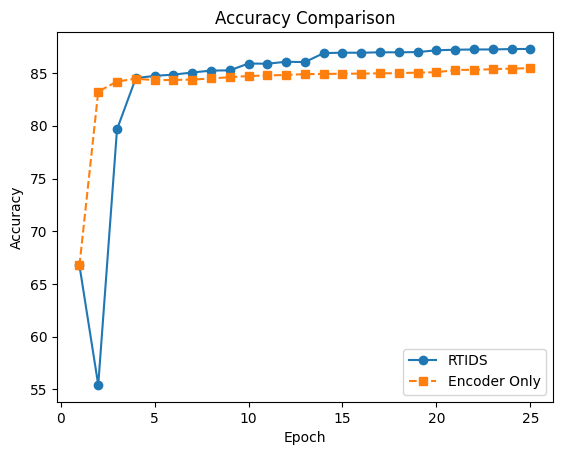

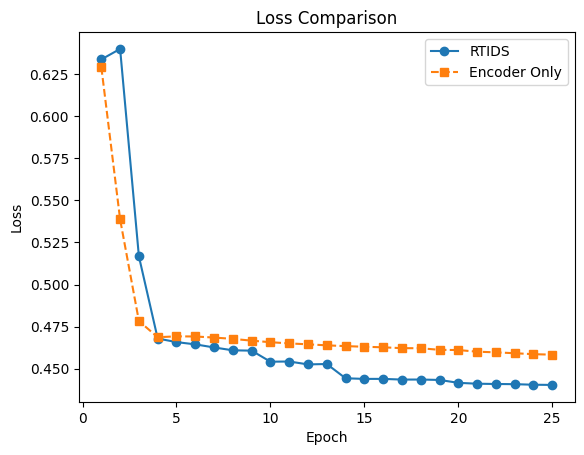

In [15]:
import matplotlib.pyplot as plt
import torch
import os

rtids_path = "pretrained/RTIDS_pretrained.pt"
encon_path = "pretrained/pretrained_enc.pt"

def analyze():
    rtids_acc = []
    rtids_los = []
    if os.path.exists(rtids_path):
        state_rtids = torch.load(rtids_path)
        rtids_acc = state_rtids["ep_acc"]
        rtids_loss = state_rtids["ep_loss"]
    
    encon_acc = []
    encon_los = []
    if os.path.exists(encon_path):
        state_encon = torch.load(encon_path)
        encon_acc = state_encon["ep_acc"]
        encon_loss = state_encon["ep_loss"]

    rtids_x_values = list(range(1, len(rtids_acc) + 1))
    encon_x_values = list(range(1, len(encon_acc) + 1))

    plt.figure(1)
    plt.plot(rtids_x_values, rtids_acc, label='RTIDS', marker='o', linestyle='-')
    plt.plot(encon_x_values, encon_acc, label='Encoder Only', marker='s', linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.legend()
    plt.show()

    plt.figure(2)
    plt.plot(rtids_x_values, rtids_loss, label='RTIDS', marker='o', linestyle='-')
    plt.plot(encon_x_values, encon_loss, label='Encoder Only', marker='s', linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Comparison')
    plt.legend()
    plt.show()

    
analyze()

As evident in the Diagrams, the RTIDS model achieves a maximum Accuracy of around 87% after 25 Epochs. Noticably, after epoch 2, the model performance drops off significantly before increasing again after epoch 3. Beginning after epoch 10, the model achieves 85% Accuracy with only minimal increases afterwards.

The Encoder Only Model achieves a maximum Accuracy of roughly 85% after epoch 25, with only minimal increases after epoch 4.

### Model Performance
In this Part I will analyze the Accuracy of each model per Class. It is important to note that this analysis is not using the furthest trained state of the models, but rather the state with the highest accuracy during training. On the most recent set of training data, this happens to be after 25 epochs, on older version, sometimes the performance dropped off after 15 to 20 epochs, presumably due to overfitting.

It is important to note, that the results of this analysis must be taken with a grain of salt, since the model does not actually differentiate between the different attack types. However it helps to visualize which attack classes can succesfully be identified as an attack and which seem to pose problems for the model.

{}


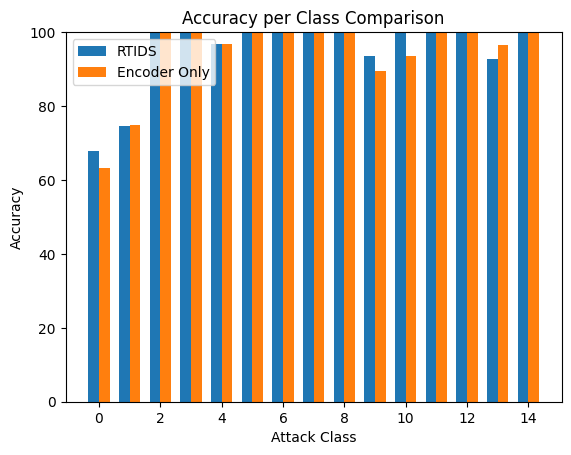

In [20]:
import matplotlib.pyplot as plt
import torch
import os
import numpy as np

max_rtids_path = "pretrained/max_RTIDS_pretrained.pt"
max_encon_path = "pretrained/max_pretrained_enc.pt"
batch_size = 128
dropout_rate = 0.5
d_model = 32
heads = 8
N = 6
trg_vocab = 2

def accuracy_per_class(model, loader):
    model.eval()
    model.to("cuda")
    correct = np.zeros(15, dtype=np.int64)
    wrong = np.zeros(15, dtype=np.int64)
    with torch.no_grad():
        for src, trg, at_class in loader:
            src, trg = src.to("cuda"), trg.to("cuda")
            output = model(src)            
            for label, pred, at_c in zip(trg, output, at_class.cpu().numpy()):
                at_c = int(at_c)
                if torch.eq(torch.argmax(pred),torch.argmax(label)):
                    correct[at_c] += 1
                else:
                    wrong[at_c] += 1
    accuracy = 100. * correct / (correct + wrong)
    return accuracy

_, val_data = load_data()
val_loader = get_data_loader(val_data, 128)

x_values = np.arange(15)

if os.path.exists(max_rtids_path):
    rtids_model = RTIDS_Transformer(trg_vocab, d_model, N, heads, dropout_rate)
    state = torch.load(max_rtids_path)
    rtids_model.load_state_dict(state["model_state_dict"])
    rtids_acc = accuracy_per_class(rtids_model, val_loader)
else:
    rtids_acc = [0 for _ in range(15)]
    
if os.path.exists(max_encon_path):
    encon_model = IDS_Encoder_Only(trg_vocab, d_model, N, heads, dropout_rate)
    state = torch.load(max_encon_path)
    encon_model.load_state_dict(state["model_state_dict"])
    encon_acc = accuracy_per_class(encon_model, val_loader) 
else:
    encon_acc = [0 for _ in range(15)]
    
plt.figure(1)
width = 0.35
plt.bar(x_values - width/2, rtids_acc, width, label='RTIDS')
plt.bar(x_values + width/2, encon_acc, width, label='Encoder Only')

plt.xlabel('Attack Class')
if label_mapping != {}:
    plt.xticks(x_values, [label_mapping[val] for val in x_values])
plt.ylabel('Accuracy')
plt.title('Accuracy per Class Comparison')
plt.ylim(0, 100)
plt.legend()
plt.show()


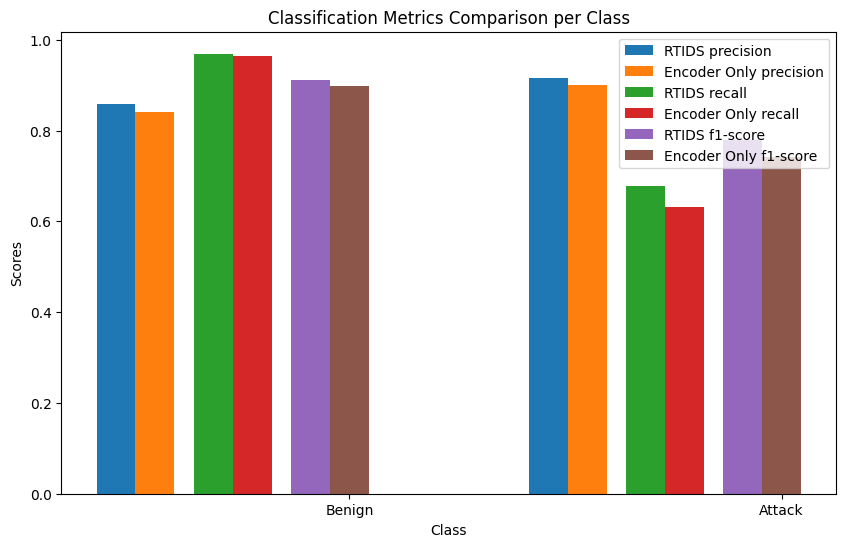

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix

max_rtids_path = "pretrained/max_RTIDS_pretrained.pt"
max_encon_path = "pretrained/max_pretrained_enc.pt"
batch_size = 128
dropout_rate = 0.5
d_model = 32
heads = 8
N = 6
trg_vocab = 2

def evaluate_binary_classification(model, loader):
    model.eval()
    model.cuda()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for src, trg, at_class in loader:
            src, trg = src.to("cuda"), trg.to("cuda")
            out = model(src)
            predicted_labels.extend(torch.argmax(out, dim=1).cpu().numpy())
            true_labels.extend(torch.argmax(trg, dim=1).cpu().numpy())

    return true_labels, predicted_labels

_, val_data = load_data()
val_loader = get_data_loader(val_data, 128)

if os.path.exists(max_rtids_path):
    rtids_model = RTIDS_Transformer(trg_vocab, d_model, N, heads, dropout_rate)
    state = torch.load(max_rtids_path)
    rtids_model.load_state_dict(state["model_state_dict"])
    
if os.path.exists(max_encon_path):
    encon_model = IDS_Encoder_Only(trg_vocab, d_model, N, heads, dropout_rate)
    state = torch.load(max_encon_path)
    encon_model.load_state_dict(state["model_state_dict"])

true_labels_rtids, predicted_labels_rtids = evaluate_binary_classification(rtids_model, val_loader)
classification_rep_rtids = classification_report(true_labels_rtids, predicted_labels_rtids, target_names=["Benign", "Attack"], output_dict=True)

true_labels_encon, predicted_labels_encon = evaluate_binary_classification(encon_model, val_loader)
classification_rep_encon = classification_report(true_labels_encon, predicted_labels_encon, target_names=["Benign", "Attack"], output_dict=True)

class_names = ["Benign", "Attack"]
metrics = ["precision", "recall", "f1-score"]
rtids_metrics = {metric: [classification_rep_rtids[class_name][metric] for class_name in class_names] for metric in metrics}
encon_metrics = {metric: [classification_rep_encon[class_name][metric] for class_name in class_names] for metric in metrics}

bar_width = 0.09
index = np.arange(len(class_names), dtype=float)
fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    rtids_bars = ax.bar(index - bar_width/2, rtids_metrics[metric], bar_width, label=f"RTIDS {metric}")
    encon_bars = ax.bar(index + bar_width/2, encon_metrics[metric], bar_width, label=f"Encoder Only {metric}")
    
    index += bar_width*2.5

ax.set_xlabel("Class")
ax.set_ylabel("Scores")
ax.set_title("Classification Metrics Comparison per Class")
ax.set_xticks(index - bar_width/2 - (bar_width/2 * len(metrics)))
ax.set_xticklabels(class_names)
ax.legend()

plt.show()

## Discussion
In comparison to the original RTIDS paper, which calimed to have achieved an accuracy of 99.35% my attempt did not perform as well. This might have several reasons:
* The original RTIDS Model has been trained on a larger Dataset. Meanwhile I had to undersample the data to enable my PC to process them, leaving me with potentially way less samples than the original workgroup.
* The Exact SMOTE Approach was not explained, so I might have used a different approach
* Some implementation details were not given in the original Paper (such as the model dimension and the Embedding Technique) and had to be estimated.
* Some Formulas in the original Paper seemed wrong or misleading, such as the double inclusion of the ReLU Function in the Feed Forward Network Calculation
* The Architecture Figure in the original Paper was either wrong or misleading, I opted to implement the transformer the usual transformer way (inputting the Encoder Output into the Decoder Multi Head Attention Layer instead of the Sequence input)

Another quite significant difference to the original Paper can be found in regards to training time. Training the model locally on my machine took roughly 33 Hours to complete the training (~110 minutes per Epoch) and roughly 10 minutes to evaluate the model. However the original paper claims to only have taken 195.6 seconds which seems definitely impossible. I can only assume that this is the time taken for evaluating the model on a better GPU than i have available, but I cannot say this with any certainty.


### Comparison to Encoder Only Architecture

As stated above, usually for Classification-Problems, an Encoder-Only Transformer Architecture is used. As evident in the Analysis above, in this case the Encoder-Only Architecture performed only slightly worse, achieving a maximum accuracy of merely 85% while my RTIDS implementation achieves 86% Accuracy. A reason for this might be the overall fewer trainable Parameters for such a complex Problem, especially the abscence of masking and multiple Attention Layers might be a factor in the reduced performance.

Overall the models perform very similarly, especially in regards to the Performance scores on "Attack"/"Benign" Classification. Both models share an extremely similar behaviour in Precision, Recall and F1-Score.

However besides the performance difference, there is also some other differences between the models. The Encoder Only Architecture trains in roughly a third of the time it takes for the RTIDS Model to train, obviously because of the fewer Parameters. At the same time, the early epochs (especially the first one) seem to train faster, achieving almost 84% Accuracy after just two Epochs. 

Especially considering the largely reduced training and evaluation time, the more stable training and the almost even performance, the Encoder-Only Architecture proves to be a viable alternative to the proposed RTIDS Architecture.

## Resources
- Z. Wu et al.: RTIDS: A Robust Transformer-Based Approach for Intrusion Detection System, Jun. 2022
  Link: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9794665
- Vaswani et al.: Attention is All you Need, 2017
  Link: https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
- Gorishniy et al.: Revisiting Deep Learning Models for Tabular Data, Nov 2021
  Link: https://arxiv.org/pdf/2106.11959v2.pdf
- (Mis)use of the CICIDS 2017 Dataset in Information Security Research, Nov. 2022
  Link: https://www.researchgate.net/publication/365062293_Misuse_of_the_CICIDS_2017_Dataset_in_Information_Security_Research
- G. Giacaglia: How Transformers Work, Mar 2019
  Link: https://towardsdatascience.com/transformers-141e32e69591